In [32]:
import numpy as np
import pickle
from pymoo.core.problem import ElementwiseProblem
from tools.HullParameterization import Hull_Parameterization as HP

with open('Min_Drag_Hull_Parameters.pkl', 'rb') as f:
    starting_designs_params = pickle.load(f)
    #low_drag_pop = pickle.load(f)

# input_params = np.array([1,2,3,4,5,6,7,8,9,10])
# optimization_tolerance = 0.1

#define upper and lower bounds using the designs provided by c ship gen
lower_bounds = []
upper_bounds = []
for i in range(len(starting_designs_params[0])):
    lower_bounds.append(min(starting_designs_params[:,i]))
    upper_bounds.append(max(starting_designs_params[:,i]))

#then modify those parameters to reflect physically meaningful bounds Arcturus must operate within
ft_to_m = 0.3048 
LOA_max = 6*ft_to_m
LOA_min = 3*ft_to_m
Bd_max = 1.5*ft_to_m/LOA_min
Bd_min = 0.5*ft_to_m/LOA_max
min_freeboard = .125*ft_to_m
lbs_to_kg = 0.453592
boat_weight_estimate = 70*lbs_to_kg
density_of_water = 1000 #kg/m^3
max_height_hulls = 10/12*ft_to_m
max_catamaran_width = 3*ft_to_m

lower_bounds[0] = LOA_min
lower_bounds[3] = Bd_min
upper_bounds[0] = LOA_max
upper_bounds[3] = Bd_max


class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=len(starting_designs_params[0]),
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=lower_bounds,
                         xu=upper_bounds)

    def _evaluate(self, x, out, *args, **kwargs):
        hull = HP(x)
        hull.Calc_VolumeProperties()
        desired_sub_vol = boat_weight_estimate/density_of_water
        
        WL_idx = np.argmin([abs(v - desired_sub_vol) for v in hull.Volumes])
        roll_sens = (2*hull.Areas_WP[WL_idx]*((max_catamaran_width-hull.Max_Beam_PC)/2)**2+2*hull.I_WP[WL_idx][0])/(desired_sub_vol)
        pitch_sens = 2*hull.I_WP[WL_idx][1]
        #heave_sens = (x[0]*x[1]) / x[2] + x[8]**(3 * x[9])

        freeboard = hull.Dd-hull.Calc_VolumeProperties()[WL_idx]-min_freeboard #freeboard constraint
        depth_of_hull = hull.Dd-max_height_hulls #depth of hull constraint

        out["F"] = [roll_sens, pitch_sens] #heave_sens
        out["G"] = [freeboard, depth_of_hull]


problem = MyProblem()

In [33]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=starting_designs_params, #change to sample from the population later 
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [34]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 300)

In [35]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       10 |      1 |  0.000000E+00 |  0.0192611433 |             - |             -
     2 |       20 |      2 |  0.000000E+00 |  0.0195225805 |  1.239582E+01 |         ideal
     3 |       30 |      1 |  0.000000E+00 |  0.0177050799 |  0.1490515861 |         ideal


LinAlgError: Singular matrix

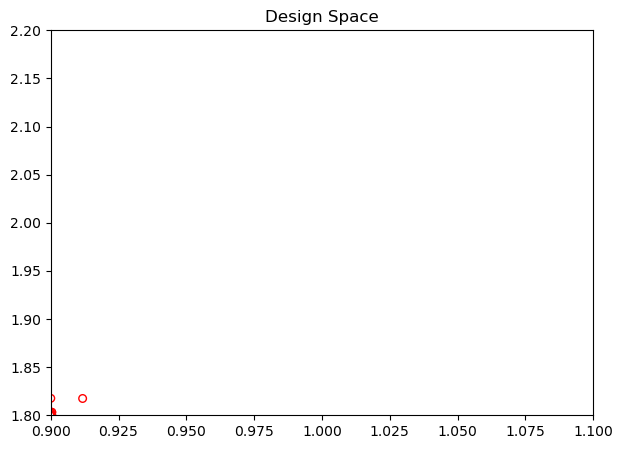

In [5]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

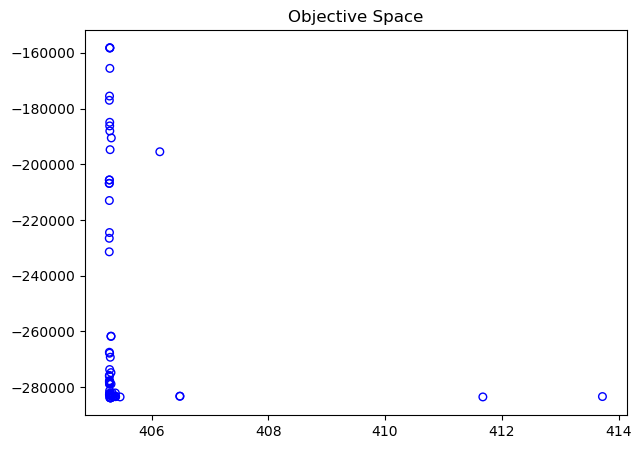

In [6]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [ ]:
#add a gradient optimizer to optimize the pareto front from NSGA2
from scipy.optimize import minimize as scipy_minimize 

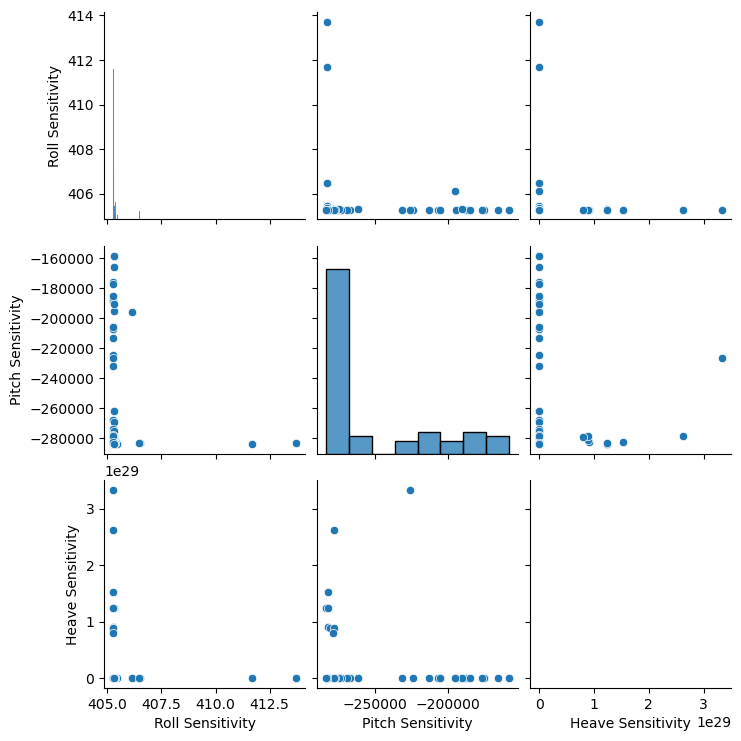

In [7]:
import seaborn as sns
import pandas as pd
F = pd.DataFrame(F, columns=["Roll Sensitivity", "Pitch Sensitivity", "Heave Sensitivity"])
sns.pairplot(F)